In [1]:
import random
import timeit
import math
import os
import numpy as np
import copy
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib import colors
import itertools as ite
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from matplotlib.path import Path
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import matplotlib.image as mpimg

%matplotlib inline

plt.rcParams["figure.figsize"] = (9,9)


In [2]:
np.random.seed(10)
random.seed(10)


In [3]:


def getnums(s, e,i=1):
    return np.array(range(s,e,i))

def check_block(blocks,limit):
    """
    Determine if path crosses the bounds of the grid. If so, forces it back in.
    """
    if max(blocks)>=limit:
        blocks-=(max(blocks)-limit)+1
    elif min(blocks)<=0:
        blocks+=(0-min(blocks))+1
    return blocks

def make_cave(grid, start_point, width=50, height=50, steps=40, noise=np.array([-1,0,1])):
    """
    makes a cave with unspesified dimentions. Likely to stretch too large if large number of steps is used.
    """
    yspot=start_point[0]
    xspot=start_point[1]
    block=np.array([-1,0,1])
    for i in range(steps):
        if xspot>=width-2*max(noise)-1:
            xspot=width-2*max(noise)-1
        if xspot<=2*max(noise)+1:
            xspot=2*max(noise)+1
        if yspot>=height-2*max(noise)-1:
            yspot=height-2*max(noise)-1
        if yspot<=2*max(noise)+1:
            yspot=2*max(noise)+1
        if random.random()<0.5:
            xspot+=random.choice(noise)
            xblocks=block+xspot
            grid[yspot][xblocks]=1
        else:
            yspot+=random.choice(noise)
            yblocks=block+yspot
            grid[yblocks,xspot]=1
    return grid



def make_cave_bound(grid,start_point,cave_height=5,cave_width=5,steps=40,noise=np.array([-1,0,1]),width=50,height=50):
    """
    Makes cave with defined max dimentions. This leads to having better defined "rooms"
    The greater the value of steps, the more full the cave. 
    As steps approaches infinity, the cave becomes a box.
    """
    yspot=start_point[0]
    xspot=start_point[1]
    block=np.array([-1,0,1])
    min_xspot=max(0,xspot-cave_width)
    max_xspot=min(width-1,xspot+cave_width)
    min_yspot=max(0,yspot-cave_height)
    max_yspot=min(height-1,yspot+cave_height)
    for i in range(steps):
        if xspot>max_xspot:
            xspot=max_xspot
        if xspot<min_xspot:
            xspot=min_xspot
        if yspot>max_yspot:
            yspot=max_yspot
        if yspot<min_yspot:
            yspot=min_yspot
        if random.random()<0.5:
            xspot+=random.choice(noise)
            xblocks=block+xspot
            xblocks=np.clip(xblocks,min_xspot,max_xspot)
            grid[yspot][xblocks]=1
        else:
            yspot+=random.choice(noise)
            yblocks=block+yspot
            yblocks=np.clip(yblocks,min_yspot,max_yspot)
            grid[yblocks,xspot]=1
    return grid


def path_to_point_any_width_path(grid,start_point,end_point,path_width=2,block_overlap=1):
    """
    grid = the map. 2D numpy array
    start_point = coordinates to start from. list of len 2. must be inside grid.
    end_point = coordinates to end at. list of len 2. must be inside grid.
    path_width = how wide the path is. one or two is recommended.
    block_overlap = affects the choppyness of the path. Reccomend doing path_width minus one (min one)
                    Will probably look weird if greater than or equal to path_width.
    
    """
    yspot=start_point[0]
    xspot=start_point[1]
    pots=[]
    neg_block=getnums(-1*path_width+1,0+1)
    pos_block=getnums(0,path_width)-(block_overlap-1)

    for i in range(abs(start_point[1]-end_point[1])):
        pots.append('x')
    for i in range(abs(start_point[0]-end_point[0])):
        pots.append('y')
    random.shuffle(pots)
    for i in range(len(pots)): 
            if random.random()<0.5:
                block=neg_block
            else:
                block=pos_block
            if start_point[0]<=end_point[0] and start_point[1]<=end_point[1]:
                if pots[i]=='y':
                    yspot+=1
                    xblocks=np.array(block)+xspot
                    xblocks = check_block(xblocks,width)
                    grid[yspot,xblocks]=1
                if pots[i]=='x':
                    xspot+=1
                    yblocks=np.array(block)+yspot
                    yblocks = check_block(yblocks,height)
                    grid[yblocks,xspot]=1
            elif start_point[0]<=end_point[0] and start_point[1]>end_point[1]:
                if pots[i]=='y':
                    yspot+=1
                    yblocks=np.array(block)+yspot
                    yblocks = check_block(yblocks,height)
                    grid[yblocks,xspot]=1
                if pots[i]=='x':
                    xspot-=1
                    xblocks=np.array(block)+xspot
                    xblocks = check_block(xblocks,width)
                    grid[yspot,xblocks]=1

            elif start_point[0]>end_point[0] and start_point[1]<=end_point[1]:
                if pots[i]=='y':
                    yspot-=1
                    yblocks=np.array(block)+yspot
                    yblocks = check_block(yblocks,height)
                    grid[yblocks,xspot]=1
                if pots[i]=='x':
                    xspot+=1
                    xblocks=np.array(block)+xspot
                    xblocks = check_block(xblocks,width)
                    grid[yspot,xblocks]=1
                
            elif start_point[0]>end_point[0] and start_point[1]>end_point[1]:
                if pots[i]=='y':
                    yspot-=1
                    yblocks=np.array(block)+yspot
                    yblocks = check_block(yblocks,height)
                    grid[yblocks,xspot]=1
                if pots[i]=='x':
                    xspot-=1
                    xblocks=np.array(block)+xspot
                    xblocks = check_block(xblocks,width)
                    grid[yspot,xblocks]=1

    return grid


Decide how many caverns and points to center the caverns.

In [21]:
height=50
width=50

grid=np.zeros((height,width))
np.random.seed(10)
random.seed(10)

xcaves=4
ycaves=2
xspots=[]
yspots=[]
caves=xcaves*ycaves
spots=[]
for i in range(xcaves):
    for j in range(ycaves):
        #print(i+i*round(width/xcaves),i+(i+1)*round(width/xcaves))
        xspot=np.random.randint(i+i*round(width/xcaves),min(i+(i+1)*round(width/xcaves),width))
        yspot=np.random.randint(j+j*round(height/ycaves),min(j+(j+1)*round(height/ycaves),height))
        spots.append([xspot,yspot])

print('The cavers will be centered at the points:')
print(spots)




The cavers will be centered at the points:
[[9, 4], [0, 43], [24, 16], [14, 34], [35, 0], [36, 34], [45, 4], [42, 42]]


Make the caverns. Because of the way this is done there is sometimes overlap between caverns so it appears there are fewer than there should be. Will fix this eventually but for now I like it becasue it makes it appear more random.

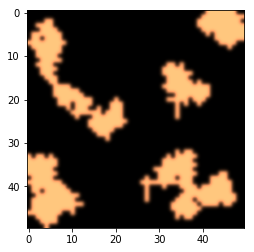

In [23]:
for i in range(len(spots)):
    grid = make_cave_bound(grid,[spots[i][0],spots[i][1]],steps=80,cave_height=10,cave_width=10)

plt.imshow(grid, cmap='copper', interpolation='gaussian')




plt.imshow(grid, cmap='copper', interpolation='gaussian')
plt.show()

Connect the caverns. Shuffle all center spots and connect them.

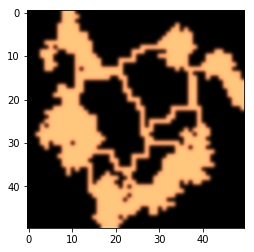

In [13]:
shuffled_spots = sorted(spots, key=lambda k: random.random())
for i in range(len(spots)-1):
    grid = path_to_point_any_width_path(grid,[shuffled_spots[i][0],shuffled_spots[i][1]],[shuffled_spots[i+1][0],shuffled_spots[i+1][1]],path_width=1,block_overlap=1)

#May do something with this liine later. Looking for more interesting ways to connect the caverns.
#pairs=list(ite.combinations(spots, 2))

plt.imshow(grid, cmap='copper', interpolation='gaussian')
plt.show()

Add images to the map. Note: Get images besides trees, e.g. chests, bookshelves, etc. Find a better algorithm to place images in more interesting spots. Currently placed at orgin of each cavern.

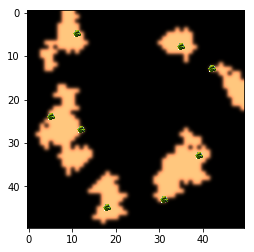

In [33]:
#plt.imshow(grid, cmap='copper', interpolation='gaussian')
#plt.show()
def place_images():
    x = np.linspace(0, 50, 20)
    y = np.cos(x)
    #grid=np.zeros((50,50))
    image_path = Image.open("tree_alpha.png")
    fig, ax = plt.subplots()
    #imscatter(x, y, image_path, zoom=0.05, ax=ax)
    imscatter(np.array(spots)[:,1], np.array(spots)[:,0], image_path, zoom=0.01, ax=ax)
    
    plt.imshow(grid, cmap='copper', interpolation='gaussian')
    plt.show()


def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

place_images()